# Using GraphSAGE to Generate Embeddings for Unseen Data

The GraphSAGE (SAmple and aggreGatE) algorithm [13] emerged in 2017 as a method for not only learning useful vertex embeddings, but also for predicting vertex embeddings on unseen vertices. This allows powerful high-level feature vectors to be produced for vertices which were not seen at train time; enabling us to effectively work with dynamic graphs, or very large graphs (>100, 000 vertices).


A GraphSAGE net is built up of k convolutional layers, called SageConv layers by the authors. Like other GNNs, they use a message-passing algorithm to combine neighbourhood features for each node. These features are then aggregated using a reduce function like max pool or mean.

## Setup
Here we load required libraries, define paths to data, and define some helper functions. **Feel free to skip this section.**

In [1]:
import numpy as np
import networkx as nx

from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import time

import torch
import torch.nn as nn
import torch.nn.functional as F

if not torch.cuda.is_available():
  !pip install dgl
else:
  !pip install dgl-cu110

import dgl


     |████████████████████████████████| 39.9MB 68kB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


## Datasets

In this example we use the Cora dataset (see Figure 19) as provided by the deep learning library DGL.

The Cora dataset is oft considered ‘the MNIST of graph-based learning’ and consists of 2708 scientific publications (vertices), each classified into one of seven subfields in AI (or classes). Each vertex has a 1433 element binary feature vector, which indicates if each of the 1433 designated words appeared in the publication.

In [2]:
# To demonstrate let's use the Cora dataset
# DGL provides an api to access this and other datasets.
import dgl.data 
data = dgl.data.CoraGraphDataset()
print('Number of categories:', data.num_classes)

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7


There are 2708 nodes and 10556 edges
Each node has 1433 features
There are 7 classes


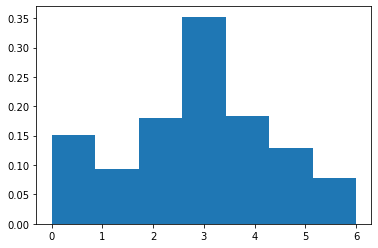

In [3]:
# DGL datasets come with a pre-initialised graph
g = data[0]
features = g.ndata['feat']
# that will download and cache the data for use later
# let's investigate
n_features = int(features.shape[1])
n_nodes = int(features.shape[0])
n_edges = g.number_of_edges()

print(f'There are {n_nodes} nodes and {n_edges} edges')
print(f'Each node has {n_features} features')

# # let's look at the labels, the classification target
labels = g.ndata['label']
n_classes = labels.max() + 1
print(f"There are {n_classes} classes")
fig, ax = plt.subplots()
n, bins, patches = ax.hist(labels.flatten()[:20000], bins=n_classes, density=True)
plt.show()
# plt.hist(labels.flatten()[:20000], bins=n_classes)

In [4]:
# DGL datasets come preprepared with train/test/val splits, in the form of index masks
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
print(int(train_mask.sum()), 'train samples')
print(int(val_mask.sum()), 'validation samples')
print(int(test_mask.sum()), 'test samples')

140 train samples
500 validation samples
1000 test samples


In [5]:
# Let's convert the data from numpy arrays to the required pytorch tensors. 
features = torch.FloatTensor(features)
labels = torch.LongTensor(labels)
train_mask = torch.BoolTensor(train_mask)
val_mask = torch.BoolTensor(val_mask)
test_mask = torch.BoolTensor(test_mask)

In [6]:
# If we are using the gpu, we can send the arrays to gpu memory.
print(torch.cuda.is_available())
gpu = torch.device('cpu')
if torch.cuda.is_available():
    gpu = torch.device('cuda:0')
    torch.cuda.set_device(gpu)
    features = features.cuda()
    labels = labels.cuda()
    train_mask = train_mask.cuda()
    val_mask = val_mask.cuda()
    test_mask = test_mask.cuda()   

True


A subgraph of the Cora dataset. The full Cora graph has N = 2708 and M = 5429. Note the many vertices with few incident edges (low degree) as compared to the few vertices with many incident edges (high degree).

/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:285: UserWarning: Property dataset.graph will be deprecated, please use dataset[0] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


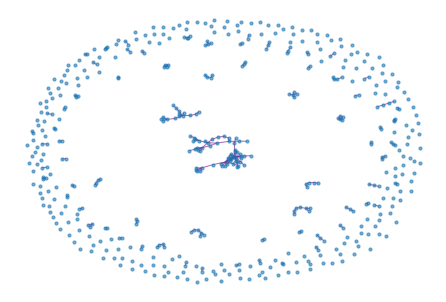

In [7]:
# DGL datasets come with a pre-initialised networkx graph
gx = data.graph

# first remove any existing self-loops, because graphSAGE employs
# its own way of dealing with self-loops in the forward pass
gx.remove_edges_from(nx.selfloop_edges(gx))
# and lets recalc the num of edges for later
n_edges = gx.number_of_edges()
# for simplicity lets convert the graph to an undirected one
gx = gx.to_undirected()

# with a networkx graph we can do some plotting
# lets just plot a fraction of the nodes
gx_copy = gx.copy()
gx_copy.remove_nodes_from(range(500, n_nodes))
nx.draw(gx_copy, node_size=10, alpha=0.6, arrows=False, edge_color='purple')

In [8]:
# We can build a trainable GNN out of this networkx graph with dgl/
# The DGLGraph can take a networkx graph as input
g = dgl.from_networkx(gx)
if torch.cuda.is_available():
  g = g.to(gpu)

## Architecture and initial experiments

We'll start by setting up our own layers, models, and training routines.

In [9]:
# Like all layers and neural nets in pytorch we will inherit the Module class
class MeanAggSageLayer(nn.Module):
    def __init__(self, n_features_in, n_features_out):
        super(MeanAggSageLayer, self).__init__()
        # number of features coming in to this layer. If this is the first layer, 
        # this will be the amount of features per node
        self._in = n_features_in
        # the number of output features from this layer,
        # In the final layer of the GraphSAGE net this will equal n_classes 
        self._out = n_features_out
        # create a linear transformation between the input channels and the output.
        # These nn.Linear objects are shortcuts to hold the weights and biases
        # that are learnt through backpropogation, and applied
        # to incoming features. We will have one for self nodes 
        self.fc_self = nn.Linear(self._in, self._out)
        # and one for neighbour nodes 
        self.fc_neigh = nn.Linear(self._in, self._out)
        # we will initialise the weights with xavier_unform random
        # sampling, another name for Glorot uniform used in the original
        # graphsage paper
        gain = nn.init.calculate_gain('relu')   # sqrt(2)
        # set the gain appropriately for our activation function 
        nn.init.xavier_uniform_(self.fc_self.weight, gain=gain)
        nn.init.xavier_uniform_(self.fc_neigh.weight, gain=gain)
    
    def forward(self, graph, features):
        """
        The following code is DGL's way of using the graph class
        to facilitate message passing. The equivalent code in pure pytorch
        operating instead on the adjacency matrix adj and the feature matrix x would be:
            
            def forward(self, x, adj):
                return adj.matmul(x, reduce='mean') @ self_weights + x @ neigh_weights + bias
        
        """
        # set the incoming features matrix as the input to this layer 'h'
        graph.srcdata['h'] = features
        # create 2 user defined functions, the first to collect features 
        # from the src nodes 'h', send along edges 'm', and aggregate them at the 
        # destination nodes (the neighbours)
        features_from_src_nodes = dgl.function.copy_src('h', 'm')
        aggregation_at_dst_nodes = dgl.function.mean('m', 'neigh')
        # graph.update_all is a helper function to send the first function
        # along the edges and recieve the second function at the
        # destination nodes
        graph.update_all(features_from_src_nodes, aggregation_at_dst_nodes)
        # now we can get our aggregated neighbourhood features
        h_neigh = graph.dstdata['neigh']
        # and combine them with the src features (self loops)
        # fc_self(features) is equivalent to features @ weights + biases
        output = self.fc_self(features) + self.fc_neigh(h_neigh)
        # lastly we add a nonlinearity to the output enabling backpropogation
        output = F.relu(output)
        return output
    

The only method we need will be the 'self.forward' method (forward pass). The backpropogation will be handled by the library.

Now lets build a graphSAGE GNN out of these layers that takes in a DGLGraph we made previously.

In [10]:
class SimpleGraphSAGE(nn.Module):
    def __init__(
            self, 
            g, 
            n_features, 
            n_hidden, 
            n_classes, 
            n_layers
    ):
        super(SimpleGraphSAGE, self).__init__()
        # A ModuleList will hold all of our layers
        self.conv_layers = nn.ModuleList()
        self.g = g

        # input layer, the input size of which will be 
        # the number of features
        self.conv_layers.append(MeanAggSageLayer(n_features, n_hidden))
        # create the hidden layers: (n_layers - 1) allowing for the output layer
        for i in range(n_layers - 1):
            self.conv_layers.append(MeanAggSageLayer(n_hidden, n_hidden))
        # output layer, the output size of which will be the number of classes
        self.conv_layers.append(MeanAggSageLayer(n_hidden, n_classes))

    def forward(self, features):
        # h(0) will be equal to the feature matrix
        h = features
        for conv in self.conv_layers:
            # pass h through one layer and back into the next
            h = conv(self.g, h)
        # now we have h(k)
        return h

Before we create one of these models we need to decide on some params:


In [11]:
n_hidden = 16
n_layers = 2
learning_rate = 0.01
weight_decay = 0.0005
n_epochs = 120

Now we can create a GraphSAGE model using our graph (g)

In [12]:
model = SimpleGraphSAGE(g, n_features, n_hidden, n_classes, n_layers)
# we can send this to gpu memory as well
if torch.cuda.is_available():
    model.cuda()

In [13]:
# use cross entropy loss function
loss_fcn = torch.nn.CrossEntropyLoss()

# use Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)

In [14]:
# we also need a scoring function, lets create a simple accuracy calculator:
def get_accuracy(pred, true):
    _, indices = torch.max(pred, dim=1)
    correct = torch.sum(indices == true)
    return correct.item() * 1.0 / len(true)

And we can decide on a simple training routine too.

In [15]:
# now our training pipeline is able to be built
def train(model, optimizer, n_epochs):
    # we will keep track how long each epoch takes so we can calculate things like
    # Traversed Edges Per Second (TEPS)
    dur = []
    all_train_logits = []

    for epoch in range(n_epochs):

        # This doesnt train the mdoel, instead it tells all the child modules
        # that the model is in training mode and not evaluating mode
        # (for examplee, when evaluating, you dont want to apply dropout to the input tensor)
        model.train()
        t0 = time.time()

        # the forward pass - sending the features to the model.forward method
        output = model(features)
        # calculate our current loss by comparing only the training nodes'
        # prediction and truth
        output_train = output[train_mask]
        loss = loss_fcn(output_train, labels[train_mask])

        # the backwards pass! update the weights in our SAGELayers - but first:
        # reset the gradient back to 0 before doing backpropogation
        # (pytorch by default accumulates the gradients after each backward pass)
        optimizer.zero_grad()
        # backpropogation
        loss.backward()
        # step the adam optimizer forward
        optimizer.step()

        dur.append(time.time() - t0)

        # set the model into evaluation model
        model.eval()
        # temporatily turn off the gradient calculation as
        # just want to simply inference
        with torch.no_grad():
            output_val = output[val_mask]
            labels_val = labels[val_mask]
            acc = get_accuracy(output_val, labels_val)

        # record the output logits for plotting later
        all_train_logits.append(output_train)

        print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | Accuracy {:.4f} | "
              "TEPS {:.2f}".format(epoch, np.mean(dur), loss.item(), acc, 
                                   n_edges / np.mean(dur)))

    print('training complete')
    return model, output, all_train_logits


In [16]:
model, last_output, _ = train(model, optimizer, n_epochs)

Epoch 00000 | Time(s) 1.6646 | Loss 2.0308 | Accuracy 0.1220 | TEPS 6341.54
Epoch 00001 | Time(s) 0.8352 | Loss 1.9779 | Accuracy 0.1480 | TEPS 12638.96
Epoch 00002 | Time(s) 0.5585 | Loss 1.9483 | Accuracy 0.2620 | TEPS 18899.54
Epoch 00003 | Time(s) 0.4202 | Loss 1.9185 | Accuracy 0.2020 | TEPS 25121.57
Epoch 00004 | Time(s) 0.3372 | Loss 1.8914 | Accuracy 0.2600 | TEPS 31305.99
Epoch 00005 | Time(s) 0.2818 | Loss 1.8588 | Accuracy 0.3700 | TEPS 37452.66
Epoch 00006 | Time(s) 0.2423 | Loss 1.8245 | Accuracy 0.4020 | TEPS 43562.81
Epoch 00007 | Time(s) 0.2128 | Loss 1.7815 | Accuracy 0.4120 | TEPS 49595.58
Epoch 00008 | Time(s) 0.1898 | Loss 1.7272 | Accuracy 0.4300 | TEPS 55607.50
Epoch 00009 | Time(s) 0.1714 | Loss 1.6670 | Accuracy 0.4180 | TEPS 61596.90
Epoch 00010 | Time(s) 0.1563 | Loss 1.6031 | Accuracy 0.4240 | TEPS 67546.34
Epoch 00011 | Time(s) 0.1437 | Loss 1.5383 | Accuracy 0.4280 | TEPS 73466.26
Epoch 00012 | Time(s) 0.1330 | Loss 1.4640 | Accuracy 0.4920 | TEPS 79351.13


In [17]:
# now we can evaluate the model on the test set
output_test = last_output[test_mask]
labels_test = labels[test_mask]
acc = get_accuracy(output_test, labels_test)
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.6790


## Further experiments

Ok so not too impressive - how can we improve the model?

For one, there are other aggregation methods used in the original paper.
DGL has implemented a SAGEConv layer that takes our simplified SageLayer further:

In [18]:
from dgl.nn.pytorch.conv.sageconv import SAGEConv

In [19]:
# A new graphSAGE net could be built as follows:
class GraphSAGE(nn.Module):
    """
    GraphSAGE pytorch implementation from paper `Inductive Representation Learning on
    Large Graphs <https://arxiv.org/pdf/1706.02216.pdf>`__.
    """
    def __init__(
            self,
            g,
            n_features,
            n_hidden,
            n_classes,
            n_layers,
            agg,
            activation,
            dropout,
    ):
        super(GraphSAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.g = g

        # input layer
        self.layers.append(
            SAGEConv(n_features, n_hidden, agg, feat_drop=dropout, activation=activation)
        )
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(
                SAGEConv(n_hidden, n_hidden, agg, feat_drop=dropout, activation=activation)
            )
        # output layer
        self.layers.append(
            SAGEConv(n_hidden, n_classes, agg, feat_drop=dropout, activation=None)
        ) # no activation None for final layer

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(self.g, h)
        return h

The 'agg' variable can now be one of ['mean', 'gcn', 'pool', 'lstm'].
Additionally, a dropout fraction can be set, activation can be changed from 'relu', and the SAGEConv layer also supports an optional normalization function.

We'll start by looking at the **mean** aggregation function:

In [20]:
# lets try our same params as before but using a dropout value of 0.5
model = GraphSAGE(g, n_features, n_hidden, n_classes, n_layers, 'mean', F.relu, 0.5)
if torch.cuda.is_available():
    model.cuda()
# initialize the optimzier again as the model params have changed
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

In [21]:
model, last_output, all_train_logits = train(model, optimizer, n_epochs)

Epoch 00000 | Time(s) 0.0095 | Loss 1.9609 | Accuracy 0.1740 | TEPS 1106296.02
Epoch 00001 | Time(s) 0.0075 | Loss 1.9309 | Accuracy 0.2180 | TEPS 1401154.25
Epoch 00002 | Time(s) 0.0067 | Loss 1.9287 | Accuracy 0.2360 | TEPS 1577271.87
Epoch 00003 | Time(s) 0.0063 | Loss 1.9125 | Accuracy 0.2100 | TEPS 1678389.39
Epoch 00004 | Time(s) 0.0061 | Loss 1.8853 | Accuracy 0.1860 | TEPS 1738145.03
Epoch 00005 | Time(s) 0.0059 | Loss 1.8630 | Accuracy 0.2400 | TEPS 1790435.11
Epoch 00006 | Time(s) 0.0061 | Loss 1.8478 | Accuracy 0.2520 | TEPS 1716791.55
Epoch 00007 | Time(s) 0.0060 | Loss 1.8173 | Accuracy 0.2660 | TEPS 1746387.59
Epoch 00008 | Time(s) 0.0060 | Loss 1.7918 | Accuracy 0.2660 | TEPS 1773351.63
Epoch 00009 | Time(s) 0.0059 | Loss 1.7333 | Accuracy 0.3340 | TEPS 1799902.15
Epoch 00010 | Time(s) 0.0058 | Loss 1.6893 | Accuracy 0.2820 | TEPS 1823861.75
Epoch 00011 | Time(s) 0.0057 | Loss 1.6241 | Accuracy 0.3180 | TEPS 1845775.28
Epoch 00012 | Time(s) 0.0059 | Loss 1.6680 | Accurac

In [22]:
acc = get_accuracy(last_output[test_mask], labels_test)
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.6790


Slightly better! Lets change the aggregation function. 
in the original GraphSAGE paper they found the LSTM and pool methods generally outperformed the mean and GCN aggregation across a range of datasets.
Lets try the **pool** method (which refers to a max pool aggregator over the neighbourhood) and bump the number of hidden channels up.

In [23]:
model = GraphSAGE(g, n_features, 128, n_classes, 2, 'pool', F.relu, 0.3)
if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.003, weight_decay=weight_decay
)

In [24]:
model, last_output, all_train_logits = train(model, optimizer, n_epochs)

Epoch 00000 | Time(s) 0.0190 | Loss 1.9694 | Accuracy 0.1220 | TEPS 554728.16
Epoch 00001 | Time(s) 0.0147 | Loss 1.9235 | Accuracy 0.1300 | TEPS 718762.85
Epoch 00002 | Time(s) 0.0132 | Loss 1.9324 | Accuracy 0.1460 | TEPS 801189.61
Epoch 00003 | Time(s) 0.0124 | Loss 1.8544 | Accuracy 0.2440 | TEPS 851108.18
Epoch 00004 | Time(s) 0.0122 | Loss 1.7394 | Accuracy 0.2260 | TEPS 866582.24
Epoch 00005 | Time(s) 0.0118 | Loss 1.7740 | Accuracy 0.1660 | TEPS 892546.63
Epoch 00006 | Time(s) 0.0116 | Loss 1.6723 | Accuracy 0.2180 | TEPS 912117.04
Epoch 00007 | Time(s) 0.0114 | Loss 1.5531 | Accuracy 0.3140 | TEPS 925876.63
Epoch 00008 | Time(s) 0.0116 | Loss 1.4408 | Accuracy 0.3940 | TEPS 913603.92
Epoch 00009 | Time(s) 0.0114 | Loss 1.4260 | Accuracy 0.3620 | TEPS 925681.60
Epoch 00010 | Time(s) 0.0111 | Loss 1.2600 | Accuracy 0.4380 | TEPS 949042.44
Epoch 00011 | Time(s) 0.0109 | Loss 1.2367 | Accuracy 0.4500 | TEPS 970806.20
Epoch 00012 | Time(s) 0.0107 | Loss 1.0003 | Accuracy 0.5120 | T

In [25]:
acc = get_accuracy(last_output[test_mask], labels_test)
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.7500


And finally the **LSTM** aggregation function:

In [26]:
model = GraphSAGE(g, n_features, 128, n_classes, 2, 'lstm', F.relu, 0.1)
if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.003, weight_decay=weight_decay
)

In [ ]:
model, last_output, all_train_logits = train(model, optimizer, n_epochs)

Epoch 00000 | Time(s) 0.4972 | Loss 1.9492 | Accuracy 0.1060 | TEPS 21232.81
Epoch 00001 | Time(s) 0.4820 | Loss 1.9285 | Accuracy 0.0900 | TEPS 21898.38
Epoch 00002 | Time(s) 0.4774 | Loss 1.9310 | Accuracy 0.2720 | TEPS 22113.68
Epoch 00003 | Time(s) 0.4725 | Loss 1.8781 | Accuracy 0.1520 | TEPS 22340.10
Epoch 00004 | Time(s) 0.4701 | Loss 1.8380 | Accuracy 0.1400 | TEPS 22453.59
Epoch 00005 | Time(s) 0.4686 | Loss 1.7596 | Accuracy 0.2060 | TEPS 22525.55


In [ ]:
acc = get_accuracy(last_output[test_mask], labels_test)
print("Test Accuracy {:.4f}".format(acc))

Not bad! See how high you can get the accuracy with some tweaking. 
Compare against the state-of-the-art here: https://paperswithcode.com/sota/node-classification-on-cora

We can plot an animation of the predictions during training (although we are limited to 2D)

In [ ]:
# one colour for each class
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink']
# to keep the graph small lets only consider training nodes
train_nodes = train_mask.cpu().numpy()
labels_train = labels[train_mask]
non_train = np.ones(len(train_nodes))
non_train[train_nodes] = 0
non_train = np.where(non_train)[0]
if torch.cuda.is_available():
  nx_g = model.g.cpu().to_networkx()
else:
  nx_g = model.g.to_networkx()
nx_g.remove_nodes_from(non_train)
rn_nodes = range(nx_g.number_of_nodes())

In [ ]:
def draw_epoch(i):
    current_colors = []
    if torch.cuda.is_available():
        logits = all_train_logits[i].detach().cpu().numpy()
    else:
        logits = all_train_logits[i].detach().numpy()
        
    max_ix = logits.argmax(axis=1)
    
    # choose x, y position based on the magnitude of their highest 
    #min_ix = max_ix - 1
    #pos = {n: [logits[n, max_ix[n]], logits[n, min_ix[n]]] for n in rn_nodes}
    #node_size = 100
    # x=node_index, y = certainty, color=class 
    #pos = {n: [n, logits[n, max_ix[n]]] for n in rn_nodes}
    #node_size = 100
    
    # x=node_index, y = class, size = certainty
    pos = {n: [n, max_ix[n]] for n in rn_nodes}
    node_size = logits.max(axis=1) * 100
    
    # cols = [colors[max_ix[n]] for n in rn_nodes]
    # use real label for color    
    cols = [colors[labels_train[n]] for n in rn_nodes]
    
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_g, pos, node_color=cols,
            with_labels=True, node_size=node_size, ax=ax, 
            edge_color='purple', arrows=False, alpha=0.6)

fig = plt.figure(dpi=100)
fig.clf()
ax = fig.subplots()
draw_epoch(0)  # draw the prediction of the first epoch
plt.close()


In [ ]:
ani = animation.FuncAnimation(fig, draw_epoch, frames=len(all_train_logits), interval=100)

In [ ]:
HTML(ani.to_jshtml())

Note how the separation of the nodes into classes improves with more training epochs.

In [ ]:
if torch.cuda.is_available():
  logits = all_train_logits[0].cpu().detach().numpy()
else:
  logits = all_train_logits[0].detach().numpy()
logits.max(axis=1)
# logits.argmax(axis=1)
# logits